In [1]:
import dask.dataframe as dd
import dask.bag as db
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import year, month
import pyspark.sql.functions as func
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [2]:
plt.style.use("ggplot")

Note that if you are using a Unix system, use rather the command
```shell
head -n 2 ./data/yt_metadata_en.jsonl
```
by uncommenting the first line and commenting the other.

In [3]:
#!head -n 2 ./data/yt_metadata_en.jsonl
!PowerShell.exe gc "./data/yt_metadata_en.jsonl" -head 2

{"categories": "Film & Animation", "channel_id": "UCzWrhkg9eK5I8Bm3HfV-unA", "crawl_date": "2019-10-31 20:19:26.270363", "description": "Lego City Police Lego Firetruck Cartoons about Lego City Movie for kids with a nice long video to keep the kids entertained while learning and having fun with the Lego City characters from Lego City undercover. Thanks for watching!", "dislike_count": 1.0, "display_id": "SBqSc91Hn9g", "duration": 1159, "like_count": 8.0, "tags": "lego city,lego police,lego city police,lego city episodes,videos de lego city,lego policia,lego bomberos,lego fire truck,lego firetruck,lego police chase,lego robbers,lego cartoons,lego movies,lego videos for kids", "title": "Lego City Police Lego Firetruck Cartoons about Lego City Movie for kids Episodes", "upload_date": "2016-09-28 00:00:00", "view_count": 1057.0}
{"categories": "Film & Animation", "channel_id": "UCzWrhkg9eK5I8Bm3HfV-unA", "crawl_date": "2019-10-31 20:19:26.914516", "description": "Lego Marvel SuperHeroes Le

In [4]:
FILE = "data/yt_metadata_en.jsonl"

schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True)  # This field must be specified as a double as it is represented as a floating point number
])

In [5]:
df = spark.read.json(FILE, schema=schema)

In [6]:
# Cast the dislike_count, like_count and view_count to their respective integer type
df = df \
    .withColumn("dislike_count", df.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", df.like_count.cast(IntegerType())) \
    .withColumn("view_count", df.view_count.cast(LongType()))

In [7]:
df.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)



In [8]:
df.show(2, vertical=True)

-RECORD 0-----------------------------
 categories    | Film & Animation     
 channel_id    | UCzWrhkg9eK5I8Bm3... 
 crawl_date    | 2019-10-31           
 dislike_count | 1                    
 display_id    | SBqSc91Hn9g          
 duration      | 1159                 
 like_count    | 8                    
 tags          | lego city,lego po... 
 title         | Lego City Police ... 
 upload_date   | 2016-09-28           
 view_count    | 1057                 
-RECORD 1-----------------------------
 categories    | Film & Animation     
 channel_id    | UCzWrhkg9eK5I8Bm3... 
 crawl_date    | 2019-10-31           
 dislike_count | 1                    
 display_id    | UuugEl86ESY          
 duration      | 2681                 
 like_count    | 23                   
 tags          | Lego superheroes,... 
 title         | Lego Marvel Super... 
 upload_date   | 2016-09-28           
 view_count    | 12894                
only showing top 2 rows



## Basic statistics on numerical values

In [9]:
df.select("dislike_count", "duration", "like_count", "view_count").summary().show()

+-------+------------------+------------------+------------------+------------------+
|summary|     dislike_count|          duration|        like_count|        view_count|
+-------+------------------+------------------+------------------+------------------+
|  count|          71293336|          72924794|          71293336|          72924140|
|   mean|  76.0915862037933| 757.6761375561788|1306.7580320831107|125237.60820707656|
| stddev|3064.7580067517442|1820.1105064271235|20135.880453098183|  3534488.21672248|
|    min|                 0|                 1|                 0|                 0|
|    25%|                 0|               134|                 6|               532|
|    50%|                 2|               284|                43|              2925|
|    75%|                12|               697|               265|             17423|
|    max|          16916346|            360157|          35287325|        6509934494|
+-------+------------------+------------------+-------

## Total number of video entries

The count is $72924794$

In [10]:
df.count()

72924794

# Show number of videos created each month

In [12]:
# Extract year from upload_date
df_dates = df\
    .withColumn("year", year(df.upload_date))\
    .withColumn("month", month(df.upload_date))
df_dates.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [13]:
# Group the videos by year and month and count the number of such videos
vids_per_month = df_dates.select("display_id", "year", "month").groupBy("year", "month").count()

In [14]:
# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count = vids_per_month.toPandas()

In [15]:
count_sorted = count.sort_values(["year", "month"])

In [16]:
count_sorted["date"] = pd.to_datetime(count_sorted["year"].astype(str) + count_sorted["month"].astype(str), format="%Y%m")

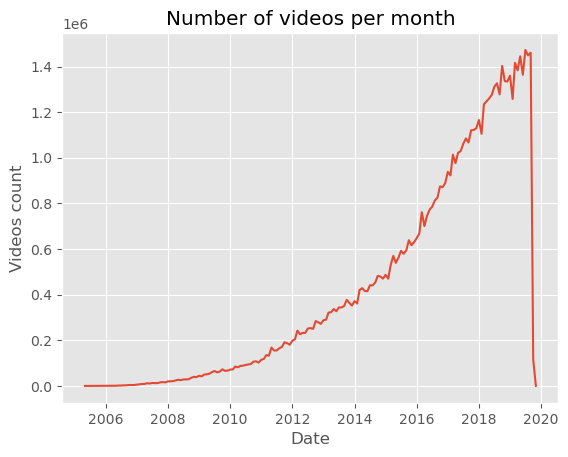

In [17]:
sns.lineplot(data=count_sorted, x="date", y="count")
plt.title("Number of videos per month")
plt.xlabel("Date")
plt.ylabel("Videos count")
plt.show()

# Group videos by year and categories

In [18]:
# Group the videos by year and month and count the number of such videos
vids_per_month_per_cat = df_dates.select("display_id", "categories", "year").groupBy("year", "categories").count()

In [19]:
# Convert the Spark dataframe into a Pandas dataframe to easily plot the values
count_cat = vids_per_month_per_cat.toPandas()

In [22]:
count_cat.head()

,year,categories,count
0,2019,Entertainment,2226961
1,2010,News & Politics,97464
2,2014,Comedy,90952
3,2019,News & Politics,2566841
4,2011,Music,285111


Categories are:
```python
{
    'Autos & Vehicles',
    'Comedy',
    'Education',
    'Entertainment',
    'Film & Animation',
    'Gaming',
    'Howto & Style',
    'Movies',
    'Music',
    'News & Politics',
    'Nonprofits & Activism',
    'People & Blogs',
    'Pets & Animals',
    'Science & Technology',
    'Shows',
    'Sports',
    'Travel & Events'
}
```

In [116]:
cats = set()
for x in count_cat.categories:
    cats.add(x)
cats

{'',
 'Autos & Vehicles',
 'Comedy',
 'Education',
 'Entertainment',
 'Film & Animation',
 'Gaming',
 'Howto & Style',
 'Movies',
 'Music',
 'News & Politics',
 'Nonprofits & Activism',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Shows',
 'Sports',
 'Travel & Events'}

In [202]:
count_cat_idx = count_cat.set_index(['year', 'categories'])

In [203]:
count_cat_idx = count_cat_idx.unstack(fill_value=0)["count"].unstack().reset_index(name='count').reset_index()

In [208]:
stack = {}
years = range(2005, 2020)
for cat in cats:
    stack[cat] = count_cat_idx[count_cat_idx["categories"] == cat].sort_values("year")["count"].values
stack['None'] = stack.pop('')
stack

{'Comedy': array([    29,   1813,   5694,   9555,  14795,  18945,  32902,  50393,
         68485,  90952, 124527, 164941, 212665, 224823, 151984],
       dtype=int64),
 'Music': array([     10,    4675,   22956,   51183,  116200,  174585,  285111,
         404498,  521508,  653974,  795565, 1012825, 1320471, 1612171,
        1329271], dtype=int64),
 'People & Blogs': array([      0,    1319,   13672,   31167,   60399,   66036,   97349,
         156526,  221188,  411033,  635832, 1012489, 1411483, 1684526,
        1107647], dtype=int64),
 'Shows': array([ 0,  0,  0,  0,  0,  0,  0, 39,  2,  0,  0,  0,  0,  0,  0],
       dtype=int64),
 'Travel & Events': array([   123,    829,   4979,  11130,  21174,  31476,  45701,  67591,
         83874,  78988, 127107, 135793, 160395, 181124, 146281],
       dtype=int64),
 'News & Politics': array([      7,    1317,   14360,   25270,   67463,   97464,  169560,
         246839,  349808,  460032,  596981,  873908, 1290183, 2120989,
        2566841], dt

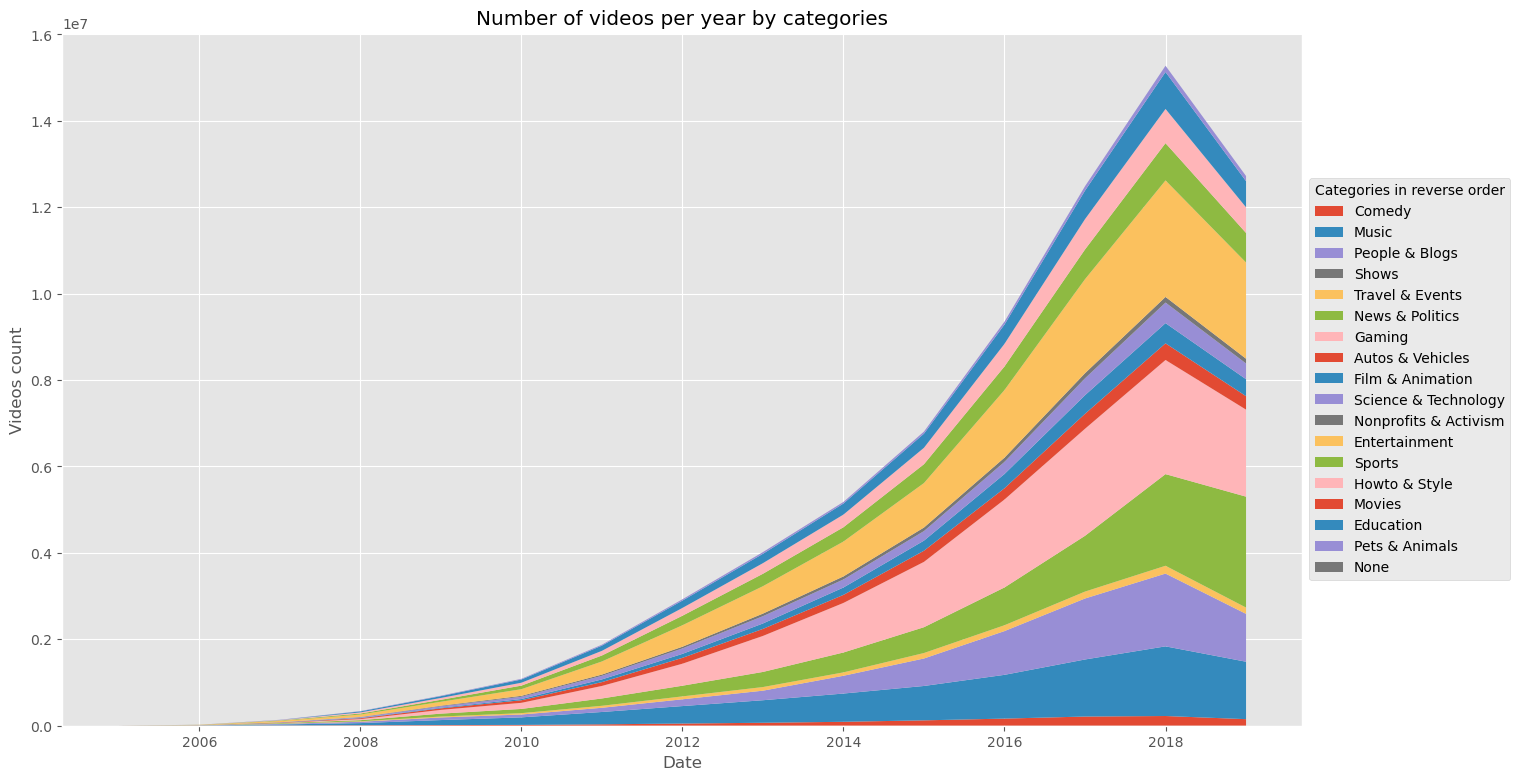

In [232]:
plt.figure(figsize=(16,9))
#ax = sns.FacetGrid(data=count_cat, x="year", y="count", hue="categories", palette=sns.color_palette("Paired"))
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# for k, v in stack.items():
#     plt.bar(years, v, label=k)
plt.stackplot(years, stack.values(), labels=stack.keys())
plt.title("Number of videos per year by categories")
plt.xlabel("Date")
plt.ylabel("Videos count")
#plt.yscale('log')
plt.legend(title='Categories in reverse order', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()